In [ ]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver

from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

In [2]:
import time
driver.get("https://cms.indianrail.gov.in/CMSREPORT/JSPRWD/rpt/ReportLogin.jsp")
#!wget -O https://cms.indianrail.gov.in/CMSREPORT/JSPRWD/rpt/ReportLogin.jsp
html = driver.page_source
#print(html)

In [3]:
Func = open("demo.html","w")
   
# Adding input data to the HTML file
Func.write(html)
              
# Saving the data into the HTML file
Func.close()

In [ ]:
f=open("demo.html")
html=f.read()
#print(html)
f.close()


In [8]:
from bs4 import BeautifulSoup


def idnames(markup):
  #markup = '<input type="text" id="fname" name="fname">'
  soup = BeautifulSoup(markup.strip(), 'html.parser')
  
  #finding the div with the id
  el=soup.find_all()
  print(el,markup)
  d=el[0].attrs
  if "id" in d:
    return d["id"]
  else:
    return ""

In [ ]:
## TRAINING THE MODEL
!pip install transformers
!pip install sentencepiece

In [ ]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!unzip  dataset.zip

In [12]:
def cleandata(data):
  
  #data=f.read()
  ndata=data.split('\n')
  #print(ndata)
  fdata=""
  for i in ndata:
    if i.strip().startswith("<input") or i.strip().startswith("<select"):
      fdata=fdata+"  "+i+" \n "
      #print("fdata ",fdata)

  return fdata


In [ ]:
#reduced the input file size 
#on free collab GPU tier it was giving out of memory

import os

datalist1=[]
d_files=os.listdir("/content/dataset/dataset")

for i in d_files:
  f=open("/content/dataset/dataset/"+i)
  datar=f.read()
  datar=cleandata(datar)
  
  f.close()

  f1=open("/content/dataset/output/"+i.replace(".html",".txt"))
  data1=f1.read()

  f1.close()
  dl=data1.split("\n")
  intent=""
  for i in dl:
    if len(i.strip())>0:
      id=idnames(i)
      intent=intent+" "+id

  d={}
  d["Intent"]=intent
  d["Query"]=datar
  
  datalist1.append(d)  
    


In [14]:
html=cleandata(html)

In [15]:
dataset=datalist1

In [ ]:
datalist1[1]

In [ ]:
batch_size=1 #remian constant 
num_of_batches=int(len(dataset)/batch_size)
num_of_epochs=8 # no of epochs,change eopchs , try to add more data set 
print("Number of batches:"+ str(num_of_batches))

In [17]:
dev = torch.device("cuda:0") 
print("Running on the GPU")
dev

Running on the GPU


device(type='cuda', index=0)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

In [19]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [20]:
from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [21]:
import torch
torch.cuda.empty_cache()

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [23]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
    
    print('Running epoch: {}'.format(epoch))

    running_loss=0

    out = display(progress(1, num_of_batches), display_id=True)
    for i in range(num_of_batches):
        inputbatch=[]
        labelbatch=[]
        new_df=dataset[i*batch_size:i*batch_size+batch_size]
        #print(new_df)
        for indx,row in enumerate(new_df):
            input = str(row['Query'])+'</s>' 
            labels = str(row['Intent'])+'</s>' 
            #print(input)
            inputbatch.append(input)
            labelbatch.append(labels)
        #print(inputbatch)
        inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=2000,return_tensors='pt')["input_ids"]
        labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=2000,return_tensors="pt") ["input_ids"]
        inputbatch=inputbatch.to(dev)
        labelbatch=labelbatch.to(dev)
       

        # clear out the gradients of all Variables 
        optimizer.zero_grad()
        
        
        # Forward propogation
        outputs = model(input_ids=inputbatch, labels=labelbatch)
        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        if i%10 ==0:      
            loss_per_10_steps.append(loss_num)
        out.update(progress(loss_num,i, num_of_batches))

        # calculating the gradients
        loss.backward()

        #updating the params
        optimizer.step()
        #free_gpu_cache()

    running_loss=running_loss/int(num_of_batches)
    print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

Running epoch: 1


Epoch: 1 , Running loss: 2.4424758712450663
Running epoch: 2


Epoch: 2 , Running loss: 1.5552433470884959
Running epoch: 3


Epoch: 3 , Running loss: 1.2091669539610546
Running epoch: 4


Epoch: 4 , Running loss: 1.0932383865118027
Running epoch: 5


Epoch: 5 , Running loss: 0.8221394633253415
Running epoch: 6


Epoch: 6 , Running loss: 0.6905561414857705
Running epoch: 7


Epoch: 7 , Running loss: 0.5686092457423607
Running epoch: 8


Epoch: 8 , Running loss: 0.603662733733654


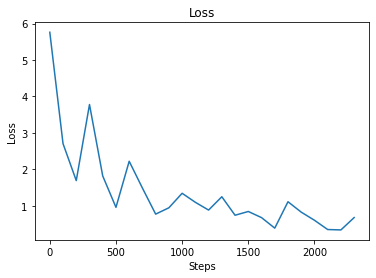

In [24]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [25]:
def generateQuery(text):
    model.eval()
    input_ids = tokenizer.encode(text, return_tensors="pt")  # Batch size 1
    #print(text)
    #print(input_ids)
    input_ids = input_ids.to(dev)
    #s = time.time()
    outputs = model.generate(input_ids,max_length=400,num_beams=4,early_stopping=True)
    gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
    #elapsed = time.time() - s
    #print('Generated in {} seconds'.format(str(elapsed)[:4]))
    return gen_text


In [26]:
model.eval()
input_ids = tokenizer.batch_encode_plus( [ html +" </s>"], padding=True, return_tensors="pt")["input_ids"]  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids,max_length=70,num_beams=4,early_stopping=False)
print(outputs)
lst=[]
for o in outputs:
    print(type(tokenizer.decode(o)))
    lst = tokenizer.decode(o).split(" ")
    # lst.append(tokenizer.decode(o))
res = set(lst)
result=[]
for i in res:
  if i!='<pad>':
    result.append(i)
print(result)

reslt = {i: result[i] for i in range(len(result))}
print(reslt)

import json
from datetime import datetime

# Get current date and time
now = datetime.now()

# extract attributes 
print("Year:", now.year)
print("Month:", now.month)
print("Day =", now.day)

print("Hour:", now.hour)
print("Minute:", now.minute)
print("Second:", now.second)
print("Microsecond:", now.microsecond)

string = str(now.day) + str(now.month) + str(now.year) + str(now.hour) + str(now.minute) + str(now.second) + str(now.microsecond)[:2]

path = string+'.json'
with open(path, 'w') as fp:
    json.dump(reslt, fp)

tensor([[  0,   3, 115,  17,  29, 536,   3, 115,  17,  29, 357,   3, 115,  17,
          29, 519,   3, 115,  17,  29, 519,   3, 115,  17,  29, 519,   3, 115,
          17,  29, 591,   3, 115,  17,  29, 519,   3, 115,  17,  29, 591,   3,
         115,  17,  29, 519,   3, 115,  17,  29, 591,   3, 115,  17,  29, 519,
           3, 115,  17,  29, 591,   3, 115,  17,  29, 519,   3, 115,  17,  29]],
       device='cuda:0')
<class 'str'>
['btn', 'btn4', 'btn1', 'btn2', 'btn3']
{0: 'btn', 1: 'btn4', 2: 'btn1', 3: 'btn2', 4: 'btn3'}
Year: 2022
Month: 11
Day = 4
Hour: 5
Minute: 23
Second: 53
Microsecond: 440145


In [ ]:
dataset[14]['Query']

In [ ]:
#!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-large-config.json

In [ ]:
torch.save(model.state_dict(),'mymodel.bin')

In [ ]:
#Inference
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
model = T5ForConditionalGeneration.from_pretrained('/content/drive/MyDrive/pytoch_model_with_augmented_data.bin', return_dict=True,config='t5-base-config.json')
tokenizer = T5Tokenizer.from_pretrained('t5-base')


In [ ]:
#Inference
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
model = T5ForConditionalGeneration.from_pretrained('/content/drive/MyDrive/pytoch_model_with_augmented_data.bin', return_dict=True,config='t5-base-config.json')
tokenizer = T5Tokenizer.from_pretrained('t5-base')